<center>
    <h1>Human Value Detection - Machine Learning</h1>
    <h2>Bonini Roberto, Maidana Facundo Nicolas</h2>
    <h3>roberto.bonini@studio.unibo.it, facundo.maidana@studio.unibo.it</h3>
</center>

## Requirements

In [ ]:
!pip install --quiet -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.5 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%cd /content
!rm -r human-value-detection
!git clone https://github.com/maidacundo/human-value-detection.git
%cd human-value-detection

/content
rm: cannot remove 'human-value-detection': No such file or directory
Cloning into 'human-value-detection'...
remote: Enumerating objects: 727, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 727 (delta 39), reused 46 (delta 22), pack-reused 662
Receiving objects: 100% (727/727), 578.40 KiB | 18.07 MiB/s, done.
Resolving deltas: 100% (438/438), done.
/content/human-value-detection


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

from sentence_transformers import SentenceTransformer

import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

## Download the data

In [ ]:
DATA_ROOT_FOLDER = 'data'

arguments_train = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-training.tsv', delimiter='\t')
labels_train = pd.read_csv(f'{DATA_ROOT_FOLDER}/labels-training.tsv', delimiter='\t')

arguments_val = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-validation.tsv', delimiter='\t')
labels_val = pd.read_csv(f'{DATA_ROOT_FOLDER}/labels-validation.tsv', delimiter='\t')

arguments_test = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-test.tsv', delimiter='\t')

In [ ]:
labels_train = labels_train.drop(labels_train[labels_train.sum(axis=1)==0].index.values)

<ipython-input-6-94a8c4070e53>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  labels_train = labels_train.drop(labels_train[labels_train.sum(axis=1)==0].index.values)


In [ ]:
df_train_original = arguments_train.merge(labels_train)
df_test_original = arguments_val.merge(labels_val)

In [ ]:
labels_columns = labels_train.drop('Argument ID', axis=1).columns

## Data Preprocessing

In order to prepare the data for classification, we tested different kinds of preprocessing steps on the concatenation of the three columns "Conclusion", "Stance", and "Premise", including:
1. **Removing rare words**: We decided to remove from the feature space those words that might add noise and make it difficult for the model to extract meaningful patterns.

2. **Removing punctuation**: Punctuation symbols are not meaningful on their own.

3. **Removing stop words**: These are commonly occurring words, and by removing them, we can make it easier for the model to focus on more meaningful words.

We then tried to focus our attention only on the "Premise", since formally values are connected specifically with the argument's premise (Kieselet al., 2022). We experimented both with the original "Premises", as well as with the preprocess "Premises". We found out that the original encoded "Premises" yielded better performance, even wrt when incorporating the textual conclusion as context.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def count_words(dataframe):
    word_counts = {}
    for sentence in dataframe:
        words = word_tokenize(sentence)
        for word in words:
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
    return word_counts

threshold = 5

# Define a function to remove rare words from a sentence
def remove_rare_words(sentence, word_counts):
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word_counts[word] >= threshold]
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence

In [ ]:
# Define stopwords and punctuation symbols to remove
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

# Define a function to remove stopwords and punctuation from a sentence
def clean_sentence(sentence):
    # Tokenize the sentence
    words = word_tokenize(sentence.lower())
    # Remove stopwords and punctuation from the words
    words = [word for word in words if word not in stop_words and word not in punctuations]
    # Join the words to form a cleaned sentence
    cleaned_sentence = ' '.join(words)
    return cleaned_sentence

In [ ]:
def preprocess_input(df):
  df_copy = df.copy()
  premise_counts = count_words(df_copy['Premise'])
  conclusion_counts = count_words(df_copy['Conclusion'])

  df_copy['Premise'] = df_copy['Premise'].apply(remove_rare_words, args=(premise_counts,))
  df_copy['Conclusion'] = df_copy['Conclusion'].apply(remove_rare_words, args=(conclusion_counts,))

  df_copy['Premise'] = df_copy['Premise'].apply(clean_sentence)
  df_copy['Conclusion'] = df_copy['Conclusion'].apply(clean_sentence)

  return df_copy

In [ ]:
train_premises = df_train_original['Premise'].to_list()
test_premises = df_test_original['Premise'].to_list()
y_train = np.array(labels_train[labels_columns].values.tolist())
y_test = np.array(labels_val[labels_columns].values.tolist())

## **Models**
We experimented with three different supervised learning algorithms.

### **Support Vector Machine**
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

1. Effective in high dimensional spaces.
2. Still effective in cases where number of dimensions is greater than the number of samples.
3. Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
4. Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

### **Random Forest**
The random forest algorithm is an extension of the bagging method as it utilizes both bagging and feature randomness to create an uncorrelated forest of decision trees. Feature randomness, generates a random subset of features, which ensures low correlation among decision trees. While decision trees consider all the possible feature splits, random forests only select a subset of those features.

Key Benefits:
1. Reduced risk of overfitting: Decision trees run the risk of overfitting as they tend to tightly fit all the samples within training data.
2. Provides flexibility: Since random forest can handle both regression and classification tasks with a high degree of accuracy, it is a popular method among data scientists.
3. Easy to determine feature importance: Random forest makes it easy to evaluate variable importance, or contribution, to the model. There are a few ways to evaluate feature importance. Gini importance and mean decrease in impurity (MDI) are usually used to measure how much the model’s accuracy decreases when a given variable is excluded.

### **Logistic Regression Classifier**
This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1.
The logistic regression model applies a sigmoid function to the lienar combination of the input feature. During the training process, the model adjusts, usually by gradient descent, the coefficients assigned to each input feature by minimizing a loss function such ass the negative log-likelihood.

At the outset of our experiments, we explored two distinct feature types, namely the final hidden state of BERT corresponding to the special "[CLS]" token, and the Pooler output of BERT. We subsequently trained six models using these features. After hyperparameter tuning, the models' performance was evaluated, with the best results achieved as follows:

1. CLS Output, Random Forest: Macro F1-Score of 0.21
2. Pooler Output, Random Forest: Macro F1-Score of 0.22

Unfortunately, these results fell short of our expectations. Consequently, we sought to improve our sentence embeddings.

For each model we performed hyperparameter tuning using GridSearch. As validation procedure we decided to use the cross-validation, since by partitioning the available data into three sets, we would drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.


## Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks (Reimers and Gurevych, 2020)

SBERT was presented as a modification of the pretrained BERT network that uses siamese and triplet network structures to derive semantically meaningful sentence embeddings (semantically similar sentences are close in vector space) (Reimers and Gurevych, 2020).

Researchers have started to input individual sentences into BERT and to derive fixed size sentence embeddings. The most commonly used approach is to average the BERT output layer (known as BERT embeddings) or by using the output of the first token (the [CLS] token). As we will show, this common practice yields rather bad sentence embeddings, often worse than averaging GloVe embeddings (Pennington et al., 2014).

It appears that the sentence embeddings from SBERT capture well sentiment information (Reimers and Gurevych, 2020).

All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs.

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
X_train = model.encode(train_premises)
X_test = model.encode(test_premises)

### SVM

In [ ]:
svm = SVC(kernel='linear', gamma='auto', class_weight='balanced', random_state=42)
svm_moc = MultiOutputClassifier(svm)

param_grid = {'estimator__C': [0.1, 0.5, 1]}

# Perform grid search with 5-fold cross-validation using the macro F1 score as the scoring metric
grid_search = GridSearchCV(svm_moc, param_grid, cv=5, verbose=4, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

# Fit the best classifier on the full training set
svm_moc = grid_search.best_estimator_
svm_moc.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................estimator__C=0.1;, score=0.449 total time= 1.6min
[CV 2/5] END ..................estimator__C=0.1;, score=0.487 total time= 1.6min
[CV 3/5] END ..................estimator__C=0.1;, score=0.452 total time= 1.6min
[CV 4/5] END ..................estimator__C=0.1;, score=0.441 total time= 1.6min
[CV 5/5] END ..................estimator__C=0.1;, score=0.404 total time= 1.5min
[CV 1/5] END ..................estimator__C=0.5;, score=0.468 total time= 1.3min
[CV 2/5] END ..................estimator__C=0.5;, score=0.504 total time= 1.4min
[CV 3/5] END ..................estimator__C=0.5;, score=0.469 total time= 1.4min
[CV 4/5] END ..................estimator__C=0.5;, score=0.453 total time= 1.4min
[CV 5/5] END ..................estimator__C=0.5;, score=0.407 total time= 1.4min
[CV 1/5] END ....................estimator__C=1;, score=0.470 total time= 1.3min
[CV 2/5] END ....................estimator__C=1;,

MultiOutputClassifier(estimator=SVC(C=1, class_weight='balanced', gamma='auto',
                                    kernel='linear', random_state=42))

In [ ]:
# Evaluate the model
svm_test_y_pred = svm_moc.predict(X_test)
print(classification_report(y_test, svm_test_y_pred, target_names=labels_columns, zero_division=0))
svm_report = classification_report(y_test, svm_test_y_pred, target_names=labels_columns, zero_division=0, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.36      0.62      0.45       251
    Self-direction: action       0.44      0.65      0.52       496
               Stimulation       0.16      0.62      0.25       138
                  Hedonism       0.19      0.62      0.29       103
               Achievement       0.52      0.72      0.60       575
          Power: dominance       0.23      0.46      0.31       164
          Power: resources       0.35      0.86      0.49       132
                      Face       0.13      0.63      0.22       130
        Security: personal       0.67      0.80      0.73       759
        Security: societal       0.56      0.51      0.53       488
                 Tradition       0.32      0.47      0.38       172
         Conformity: rules       0.44      0.68      0.53       455
 Conformity: interpersonal       0.13      0.53      0.21        60
                  Humility       0.13      0.35

### Random Forests

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_moc = MultiOutputClassifier(rf)

param_grid = {'estimator__n_estimators': [5, 10, 20, 30], 'estimator__max_depth': [2, 4, 6, 8], 'estimator__min_samples_split': [2, 3, 4, 5]}

# Perform grid search with 5-fold cross-validation using the macro F1 score as the scoring metric
grid_search = GridSearchCV(rf_moc, param_grid, cv=5, verbose=4, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

# Fit the best classifier on the full training set
rf_moc = grid_search.best_estimator_
rf_moc.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.366 total time=   2.1s
[CV 2/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.389 total time=   2.2s
[CV 3/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.368 total time=   2.1s
[CV 4/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.353 total time=   2.1s
[CV 5/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.300 total time=   2.1s
[CV 1/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=10;, score=0.397 total time=   4.0s
[CV 2/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=10;, score=0.417 total time=   4.1s
[CV 3/5] END estimator__max_depth=2, est

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=4,
                                                       n_estimators=30,
                                                       random_state=42))

In [ ]:
# Evaluate the model
rf_test_y_pred = rf_moc.predict(X_test)

print(classification_report(y_test, rf_test_y_pred, target_names=labels_columns, zero_division=0))
rf_report = classification_report(y_test, rf_test_y_pred, target_names=labels_columns, zero_division=0, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.36      0.45      0.40       251
    Self-direction: action       0.54      0.45      0.49       496
               Stimulation       0.16      0.08      0.11       138
                  Hedonism       0.37      0.31      0.34       103
               Achievement       0.50      0.59      0.54       575
          Power: dominance       0.25      0.32      0.28       164
          Power: resources       0.34      0.67      0.45       132
                      Face       0.22      0.26      0.24       130
        Security: personal       0.63      0.64      0.63       759
        Security: societal       0.53      0.52      0.53       488
                 Tradition       0.33      0.34      0.33       172
         Conformity: rules       0.40      0.48      0.44       455
 Conformity: interpersonal       0.04      0.02      0.02        60
                  Humility       0.16      0.17

### Logistic Regression

In [ ]:
lr = LogisticRegression(class_weight='balanced', multi_class='auto', random_state=42, max_iter=10000)

lr_moc = MultiOutputClassifier(lr)
param_grid = {'estimator__C': [0.1, 0.5, 1, 2], 'estimator__solver': ['lbfgs', 'liblinear']}

# Perform grid search with 5-fold cross-validation using the macro F1 score as the scoring metric
grid_search = GridSearchCV(lr_moc, param_grid, cv=5, verbose=4, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

# Fit the best classifier on the full training set
lr_moc = grid_search.best_estimator_
lr_moc.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.457 total time=   1.0s
[CV 2/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.487 total time=   1.0s
[CV 3/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.456 total time=   1.0s
[CV 4/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.440 total time=   1.0s
[CV 5/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.399 total time=   1.5s
[CV 1/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.456 total time=   5.7s
[CV 2/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.487 total time=   6.7s
[CV 3/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.456 total time=   5.7s
[CV 4/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.440 total time=   5.5s
[CV 5/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.401 total time=   5.8s
[CV 1/5] END estimator__C=0.5, estimator

MultiOutputClassifier(estimator=LogisticRegression(C=2, class_weight='balanced',
                                                   max_iter=10000,
                                                   random_state=42))

In [ ]:
# Evaluate the model
lr_test_y_pred = lr_moc.predict(X_test)
print(classification_report(y_test, lr_test_y_pred, target_names=labels_columns, zero_division=0))
lr_report = classification_report(y_test, lr_test_y_pred, target_names=labels_columns, zero_division=0, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.35      0.64      0.45       251
    Self-direction: action       0.44      0.67      0.53       496
               Stimulation       0.18      0.59      0.27       138
                  Hedonism       0.22      0.61      0.32       103
               Achievement       0.52      0.73      0.61       575
          Power: dominance       0.21      0.44      0.28       164
          Power: resources       0.37      0.82      0.51       132
                      Face       0.14      0.64      0.22       130
        Security: personal       0.65      0.79      0.72       759
        Security: societal       0.54      0.52      0.53       488
                 Tradition       0.36      0.45      0.40       172
         Conformity: rules       0.44      0.65      0.53       455
 Conformity: interpersonal       0.13      0.48      0.21        60
                  Humility       0.12      0.31

## TF-IDF
TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used in natural language processing to measure the relevance of a word in a document or corpus. It is a product of two measures: the term frequency (TF), which measures how often a word appears in a document, and the inverse document frequency (IDF), which measures how rare the word is across the entire corpus of documents.

The basic idea behind TF-IDF is that words that appear frequently in a document but rarely across other documents are more important and informative for identifying the topic of the document. Therefore, TF-IDF assigns a high weight to these words, while giving low weight to words that appear frequently across many documents.

In [ ]:
tfidf = TfidfVectorizer(max_features=768)

In [ ]:
X_train_tfidf = tfidf.fit_transform(train_premises)
X_test_tfidf = tfidf.transform(test_premises)

### SVM

In [ ]:
svm = SVC(gamma='scale', class_weight='balanced', random_state=42)
svm_tfidf_moc = MultiOutputClassifier(svm)

param_grid = {'estimator__C': [0.1, 0.5, 1], 'estimator__kernel': ['rbf', 'linear']}

# Perform grid search with 5-fold cross-validation using the macro F1 score as the scoring metric
grid_search = GridSearchCV(svm_tfidf_moc, param_grid, cv=5, verbose=4, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END estimator__C=0.1, estimator__kernel=rbf;, score=0.430 total time= 1.2min
[CV 2/5] END estimator__C=0.1, estimator__kernel=rbf;, score=0.447 total time= 1.2min
[CV 3/5] END estimator__C=0.1, estimator__kernel=rbf;, score=0.427 total time= 1.2min
[CV 4/5] END estimator__C=0.1, estimator__kernel=rbf;, score=0.426 total time= 1.2min
[CV 5/5] END estimator__C=0.1, estimator__kernel=rbf;, score=0.277 total time= 1.1min
[CV 1/5] END estimator__C=0.1, estimator__kernel=linear;, score=0.435 total time= 1.0min
[CV 2/5] END estimator__C=0.1, estimator__kernel=linear;, score=0.464 total time= 1.0min
[CV 3/5] END estimator__C=0.1, estimator__kernel=linear;, score=0.436 total time= 1.0min
[CV 4/5] END estimator__C=0.1, estimator__kernel=linear;, score=0.427 total time= 1.0min
[CV 5/5] END estimator__C=0.1, estimator__kernel=linear;, score=0.330 total time=  56.7s
[CV 1/5] END estimator__C=0.5, estimator__kernel=rbf;, score=0.44

In [ ]:
# Fit the best classifier on the full training set
svm_tfidf_moc = grid_search.best_estimator_
svm_tfidf_moc.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=SVC(C=0.5, class_weight='balanced',
                                    random_state=42))

In [ ]:
# Evaluate the model
test_y_pred = svm_tfidf_moc.predict(X_test_tfidf)
print(classification_report(y_test, test_y_pred, target_names=labels_columns, zero_division=0))
svm_tfidf_report = classification_report(y_test, test_y_pred, target_names=labels_columns, zero_division=0, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.44      0.40      0.42       251
    Self-direction: action       0.50      0.52      0.51       496
               Stimulation       0.11      0.01      0.01       138
                  Hedonism       0.09      0.01      0.02       103
               Achievement       0.50      0.50      0.50       575
          Power: dominance       0.22      0.20      0.21       164
          Power: resources       0.39      0.48      0.43       132
                      Face       0.22      0.16      0.19       130
        Security: personal       0.59      0.62      0.61       759
        Security: societal       0.51      0.50      0.51       488
                 Tradition       0.46      0.22      0.29       172
         Conformity: rules       0.41      0.40      0.40       455
 Conformity: interpersonal       0.67      0.03      0.06        60
                  Humility       0.20      0.06

### Random forest

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_tfidf_moc = MultiOutputClassifier(rf)

param_grid = {'estimator__n_estimators': [5, 10, 20, 30], 'estimator__max_depth': [2, 4, 6, 8, 10], 'estimator__min_samples_split': [2, 3, 4, 5]}

# Perform grid search with 5-fold cross-validation using the macro F1 score as the scoring metric
grid_search = GridSearchCV(rf_tfidf_moc, param_grid, cv=5, verbose=4, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.265 total time=   0.3s
[CV 2/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.267 total time=   0.3s
[CV 3/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.230 total time=   0.3s
[CV 4/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.226 total time=   0.3s
[CV 5/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=5;, score=0.180 total time=   0.3s
[CV 1/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=10;, score=0.289 total time=   0.5s
[CV 2/5] END estimator__max_depth=2, estimator__min_samples_split=2, estimator__n_estimators=10;, score=0.320 total time=   0.5s
[CV 3/5] END estimator__max_depth=2, est

In [ ]:
rf_tfidf_moc = grid_search.best_estimator_
rf_tfidf_moc.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=6,
                                                       min_samples_split=5,
                                                       n_estimators=30,
                                                       random_state=42))

In [ ]:
# Evaluate the model
test_y_pred = rf_tfidf_moc.predict(X_test_tfidf)
print(classification_report(y_test, test_y_pred, target_names=labels_columns, zero_division=0))
rf_tfidf_report = classification_report(y_test, test_y_pred, target_names=labels_columns, zero_division=0, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.42      0.34      0.38       251
    Self-direction: action       0.54      0.42      0.47       496
               Stimulation       0.10      0.07      0.09       138
                  Hedonism       0.08      0.05      0.06       103
               Achievement       0.45      0.49      0.47       575
          Power: dominance       0.23      0.31      0.27       164
          Power: resources       0.40      0.36      0.38       132
                      Face       0.09      0.23      0.13       130
        Security: personal       0.60      0.37      0.46       759
        Security: societal       0.58      0.30      0.40       488
                 Tradition       0.30      0.23      0.26       172
         Conformity: rules       0.38      0.37      0.37       455
 Conformity: interpersonal       0.07      0.03      0.04        60
                  Humility       0.11      0.05

### Logistic Regression

In [ ]:
lr = LogisticRegression(class_weight='balanced', multi_class='auto', random_state=42, max_iter=10000)

lr_tfidf_moc = MultiOutputClassifier(lr)
param_grid = {'estimator__C': [0.1, 0.5, 1, 2], 'estimator__solver': ['lbfgs', 'liblinear']}

# Perform grid search with 5-fold cross-validation using the macro F1 score as the scoring metric
grid_search = GridSearchCV(lr_tfidf_moc, param_grid, cv=5, verbose=4, scoring='f1_macro')
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.431 total time=   0.4s
[CV 2/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.469 total time=   0.4s
[CV 3/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.441 total time=   0.4s
[CV 4/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.427 total time=   0.4s
[CV 5/5] END estimator__C=0.1, estimator__solver=lbfgs;, score=0.339 total time=   0.4s
[CV 1/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.431 total time=   0.2s
[CV 2/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.469 total time=   0.2s
[CV 3/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.441 total time=   0.2s
[CV 4/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.426 total time=   0.2s
[CV 5/5] END estimator__C=0.1, estimator__solver=liblinear;, score=0.339 total time=   0.2s
[CV 1/5] END estimator__C=0.5, estimator

In [ ]:
lr_tfidf_moc = grid_search.best_estimator_
lr_tfidf_moc.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=0.5,
                                                   class_weight='balanced',
                                                   max_iter=10000,
                                                   random_state=42,
                                                   solver='liblinear'))

In [ ]:
# Evaluate the model
lr_tfidf_test_y_pred = lr_tfidf_moc.predict(X_test_tfidf)
print(classification_report(y_test, lr_tfidf_test_y_pred, target_names=labels_columns, zero_division=0))
lr_tfidf_report = classification_report(y_test, lr_tfidf_test_y_pred, target_names=labels_columns, zero_division=0, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.32      0.53      0.40       251
    Self-direction: action       0.46      0.59      0.52       496
               Stimulation       0.13      0.33      0.18       138
                  Hedonism       0.10      0.30      0.15       103
               Achievement       0.47      0.58      0.52       575
          Power: dominance       0.17      0.40      0.24       164
          Power: resources       0.30      0.64      0.41       132
                      Face       0.15      0.50      0.23       130
        Security: personal       0.58      0.69      0.63       759
        Security: societal       0.48      0.55      0.51       488
                 Tradition       0.27      0.36      0.31       172
         Conformity: rules       0.37      0.54      0.44       455
 Conformity: interpersonal       0.09      0.25      0.13        60
                  Humility       0.08      0.20

## Plotting Functions

In [ ]:
def plot_classification_reports(reports, names, title):
  # Get the list of labels from one of the reports
  labels = list(reports[0].keys())[:20]

  # Create an array to hold the f1-scores for each report and each label
  f1_scores = np.zeros((len(reports), len(labels)))

  # Calculate the support for each label
  support = np.array([reports[0][label]['support'] for label in labels])
  support_scaled = support / support.max()  # Scale the support values

  # Populate the f1_scores array with the f1-scores for each report and each label
  for i, report in enumerate(reports):
      for j, label in enumerate(labels):
          f1_scores[i][j] = report[label]['f1-score']

  # Set up the figure with two y-axes
  fig, ax1 = plt.subplots(figsize=(10, 5))
  ax2 = ax1.twinx()

  # Plot the f1-scores for each label as lines on the top y-axis
  for i in range(len(reports)):
      ax1.plot(f1_scores[i], label=names[i])
  ax1.set_xticks(np.arange(len(labels)))
  ax1.set_xticklabels(labels, rotation=90, ha='center')
  ax1.set_xlabel('Label')
  ax1.set_ylabel('F1-score')
  ax1.legend()

  # Plot the histogram of label support on the bottom y-axis
  ax2.bar(np.arange(len(support)), support_scaled, alpha=0.15, color='purple', width=0.5)
  ax2.yaxis.set_tick_params(length=0)
  ax2.set_yticklabels([])

  # Add a secondary y-axis with the real support values
  ax3 = ax2.secondary_yaxis('right', functions=(lambda x: x * support.max(), lambda x: x / support.max()), color='purple')
  ax3.set_ylabel('Support')
  ax3.tick_params(axis='y', color='purple')

  # Adjust the layout to make room for the x-axis labels
  fig.subplots_adjust(bottom=0.4)

  fig.suptitle(title)
  # Show the plot
  plt.show()

def print_MultilabelConfusionMatrix(matrices, labels, title):
  rows = 5
  cols = 4
  f, axes = plt.subplots(rows, cols, figsize=(15, 10))
  axes = axes.ravel()
  for i in range(len(matrices)):
      disp = ConfusionMatrixDisplay(matrices[i])
      disp.plot(ax=axes[i])
      disp.ax_.set_title(labels[i])
      if i<len(matrices)-cols:
          disp.ax_.set_xlabel('')
      if i%cols!=0:
          disp.ax_.set_ylabel('')
      disp.im_.colorbar.remove()

  plt.subplots_adjust(wspace=0.05, hspace=0.5)
  f.colorbar(disp.im_, ax=axes)
  f.suptitle(title)
  plt.show()

def print_global_report(reports, names):
  dfs = []
  for i, report in enumerate(reports):
    if i == len(reports)-1:
      df = pd.DataFrame.from_dict(report, orient='index', columns=['precision', 'recall', 'f1-score', 'support'])
      dfs.append(df)
    else:
      df = pd.DataFrame.from_dict(report, orient='index', columns=['precision', 'recall', 'f1-score'])
      dfs.append(df)

  pd.options.display.float_format = '{:,.2f}'.format
  # Concatenate the dataframes into a single table
  df_combined = pd.concat(dfs, axis=1, keys=names)
  # Print the combined table
  print(df_combined.to_string())

## Error Analysis

### SBERT Embeddings: Plotting F1-Score per each label with its support.

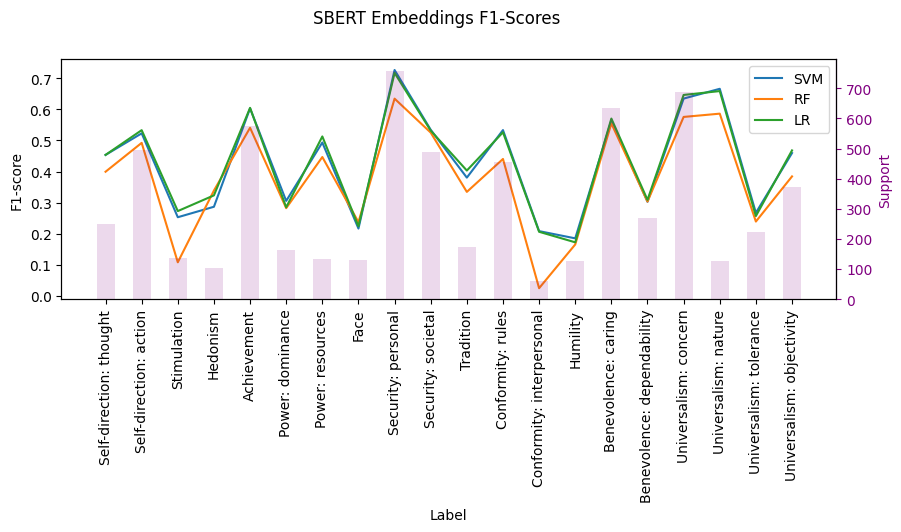

In [ ]:
names = ['SVM', 'RF', 'LR']
sbert_reports = [svm_report, rf_report, lr_report]
plot_classification_reports(sbert_reports, names, 'SBERT Embeddings F1-Scores')

From the plot it is possible to see that the trend of the F1-Scores follows the support distribution for all labels except "Power: resources" and "Universalism: nature". Thus, as we would expect, labels with higher support achieve better scores. After analyzing the classification report, the logistic regression classifier using SBERT Embeddings turned out to be the best model. It achieved good scores in most lables, with a **macro f1-score of 0.43**. The labels with lower f1-score are: **Conformity: interpersonal**, **Face**, and **Humility**. Among all the labels, these three have a small support, which might be one of the causes of the obtained results.

### TF-IDF: Plotting F1-Score per each label with its support.

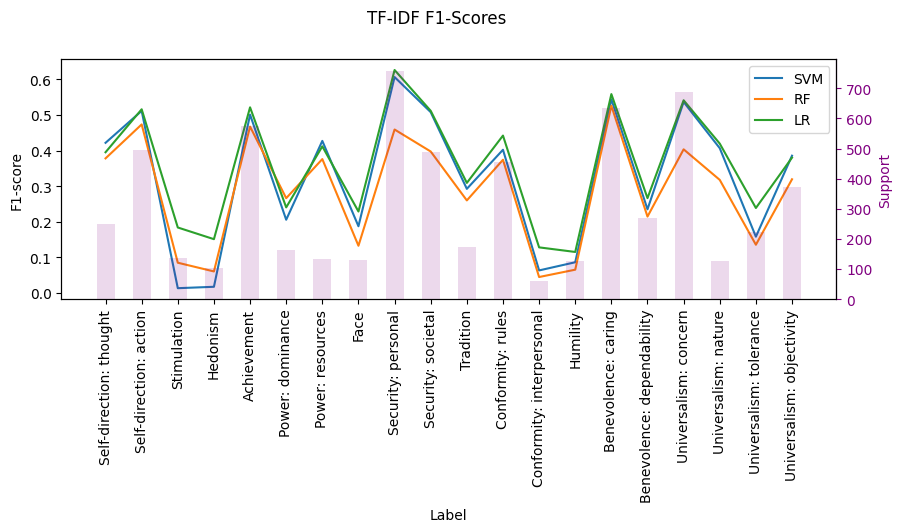

In [ ]:
tfidf_reports = [svm_tfidf_report, rf_tfidf_report, lr_tfidf_report]
plot_classification_reports(tfidf_reports, names, 'TF-IDF F1-Scores')

The same goes for the plot relative to the TF-IDF model: F1-Scores trend follows the support distribution. Here, unlike the SBERT model, the trend is more evident, since almost all the labels with low support show low F1-Score. The **macro F1-Score is 0.36**. The labels with the lower F1-Scores are **Hedonism**, **Conformity: Interpersonal**, and **Humility**.

In [ ]:
best_reports = [lr_report, lr_tfidf_report]
best_names = ['LR SBERT', 'LR TF-IDF']

### Best Model for each approach: Plotting F1-Score per each label with its support.

Logistic Regression Classificator turned out to be the best model, both for SBERT Embeddings and TF-IDF.

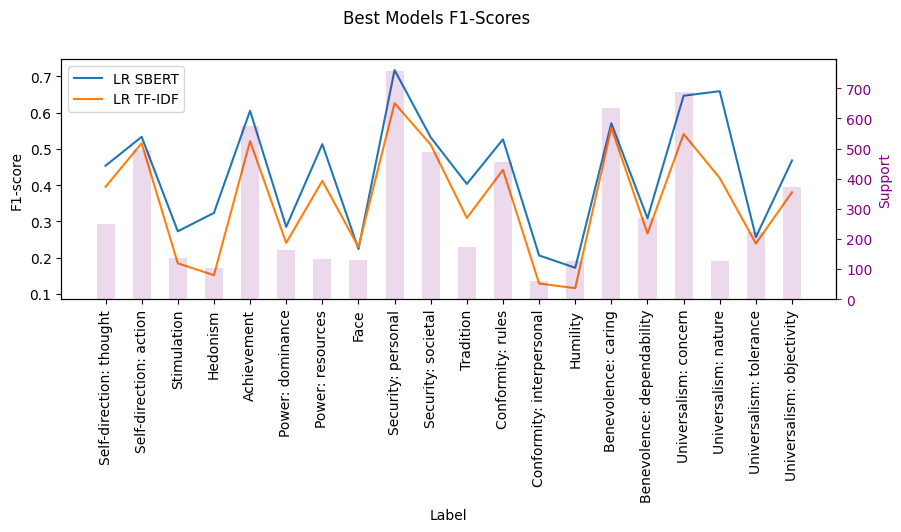

In [ ]:
plot_classification_reports(best_reports, best_names, 'Best Models F1-Scores')

In this plot, we compare the top two models using two types of features. While both models show comparable trends overall, the SBERT model exhibits better generalization for some labels with limited support.

## Global Classification Report

In [ ]:
print_global_report(best_reports, best_names)

                            LR SBERT                 LR TF-IDF                        
                           precision recall f1-score precision recall f1-score support
Self-direction: thought         0.35   0.64     0.45      0.32   0.53     0.40     251
Self-direction: action          0.44   0.67     0.53      0.46   0.59     0.52     496
Stimulation                     0.18   0.59     0.27      0.13   0.33     0.18     138
Hedonism                        0.22   0.61     0.32      0.10   0.30     0.15     103
Achievement                     0.52   0.73     0.61      0.47   0.58     0.52     575
Power: dominance                0.21   0.44     0.28      0.17   0.40     0.24     164
Power: resources                0.37   0.82     0.51      0.30   0.64     0.41     132
Face                            0.14   0.64     0.22      0.15   0.50     0.23     130
Security: personal              0.65   0.79     0.72      0.58   0.69     0.63     759
Security: societal              0.54   0.52

As we mentioned in the Data Preprocessing section, we decided to keep only the premises of the arguments for training and evaluation. We actually tested the performance using the concatenation of both premises and conclusions, but the results were either slightly worse or the same.

From the global report, we notice that both models have higher recall than precision. 

Would we prefer to have less false positives, i.e., higher precision, or less false negatives, i.e., higher recall? There should definitely be a trade-off between the two.

A higher recall (compared to models with a lower one) means recognizing more correct human values that are actually contained in the arguments (i.e., less values that are not recognized but are present in the arguments), while higher precision would mean having fewer recognized human values that are not actually present in the arguments.

The choice of having more false positives/negatives depends on the application of these types of detection systems. For the purpose of our project, we do not have a preference.

## Confusion Matrices

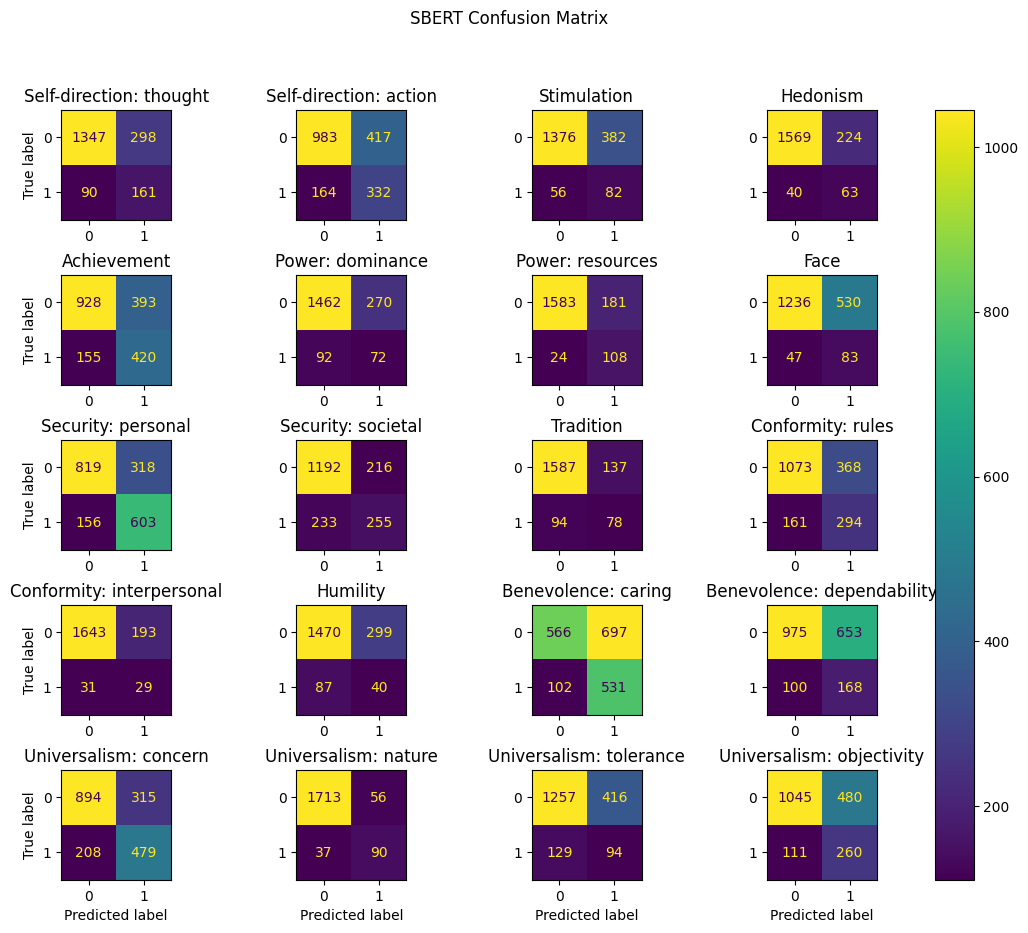

In [ ]:
sbert_cm = multilabel_confusion_matrix(y_test, lr_test_y_pred)
print_MultilabelConfusionMatrix(sbert_cm, labels_columns, 'SBERT Confusion Matrix')

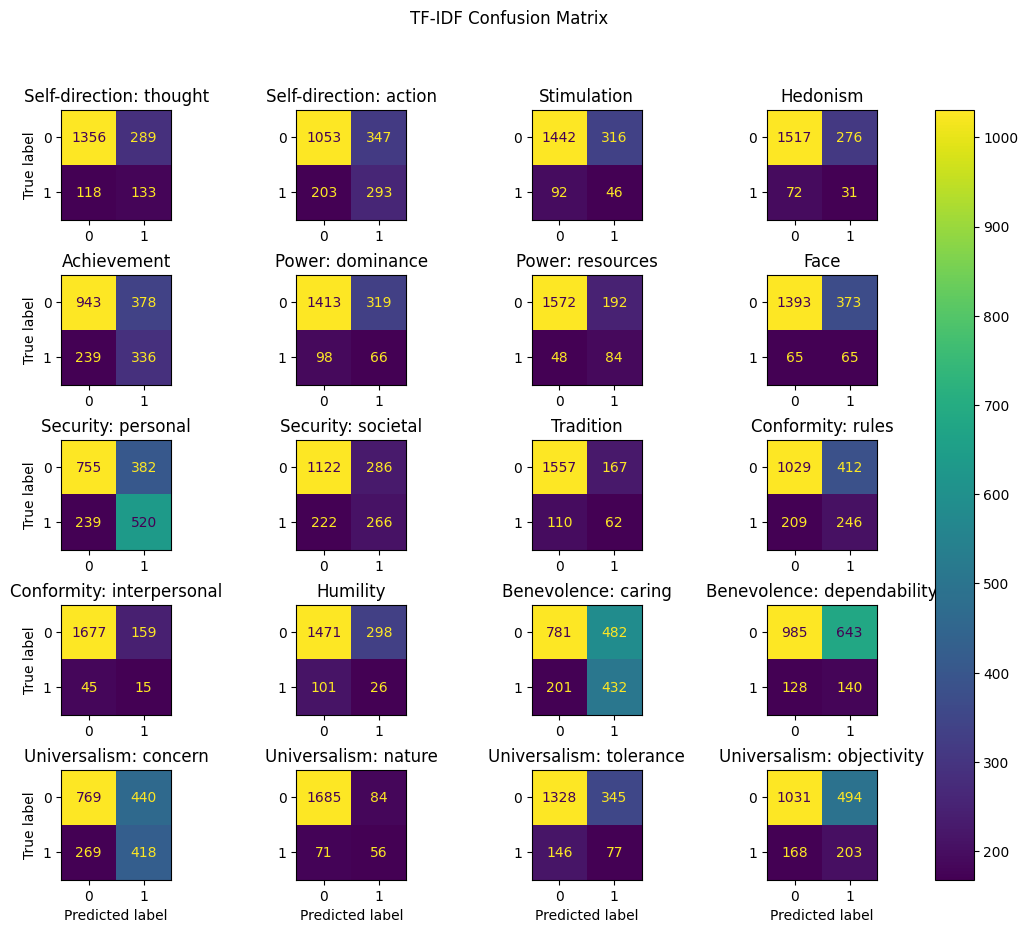

In [ ]:
tfidf_cm = multilabel_confusion_matrix(y_test, lr_tfidf_test_y_pred)
print_MultilabelConfusionMatrix(tfidf_cm, labels_columns, 'TF-IDF Confusion Matrix')

In [ ]:
#In order not to run the entire script, we saved the list of predicted labels

import _pickle as cPickle
%cd /content
with open(r"lr_test_y_pred.pickle", "rb") as input_file:
   lr_test_y_pred = cPickle.load(input_file)

with open(r"lr_tfidf_test_y_pred.pickle", "rb") as input_file:
   lr_tfidf_test_y_pred = cPickle.load(input_file)


/content


In [ ]:
def get_missclassified_arguments(true_labels, predictions, label):
  df = pd.DataFrame()
  label_idx = np.where(labels_columns.values==label)
  #errors = []
  errors_idxs = []
  for idx, error in enumerate(zip(true_labels, predictions)):
    if error[0][label_idx] != error[1][label_idx]:
      #errors.append(error[0])
      errors_idxs.append(idx)
 
  df['Premise'] = df_test_original.iloc[errors_idxs]['Premise']
  df['Stance'] = df_test_original.iloc[errors_idxs]['Stance']
  df['Conclusion'] = df_test_original.iloc[errors_idxs]['Conclusion']
  df[f"Predicted {label}"] = 1 - df_test_original.iloc[errors_idxs][label]
  return errors_idxs, df

In [ ]:
sbert_humility_idxs, sbert_humility_errors = get_missclassified_arguments(y_test, lr_test_y_pred, 'Humility')
#sbert_interpersonal_errors = get_missclassified_arguments(y_test, lr_test_y_pred, 'Conformity: interpersonal')
#sbert_face_errors = get_missclassified_arguments(y_test, lr_test_y_pred, 'Face')

To perform error analysis we could compute the cosine similarity between false positive and actual positive (the same goes for negative) and try to understand if there might be a correlation

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
#Compute embedding for both lists
#embeddings1 = model.encode(df_test_original[df_test_original['Humility']==1].to_list(), convert_to_tensor=True)
#embeddings2 = model.encode(df_test_original[df_test_original['Humility']==1].to_list(), convert_to_tensor=True)
means = {}
# Single list of sentences - Possible tens of thousands of sentences
for label in labels_columns:
  sentences = df_train_original[df_train_original[label]==1]['Premise'].to_list()
  paraphrases = util.paraphrase_mining(model, sentences)

  means[label] = np.mean([score for score, i, j in paraphrases])

In [ ]:
means

{'Self-direction: thought': 0.4250617222619707,
 'Self-direction: action': 0.4261906696621753,
 'Stimulation': 0.25469285454500745,
 'Hedonism': 0.2467048680474763,
 'Achievement': 0.4156574665315924,
 'Power: dominance': 0.3532515343108927,
 'Power: resources': 0.3805883845035653,
 'Face': 0.28477096686275544,
 'Security: personal': 0.47020021060422124,
 'Security: societal': 0.4644830750968423,
 'Tradition': 0.3979680168896612,
 'Conformity: rules': 0.40696156691291707,
 'Conformity: interpersonal': 0.2928134112688653,
 'Humility': 0.34195486315579304,
 'Benevolence: caring': 0.39847312814334773,
 'Benevolence: dependability': 0.34925127761519836,
 'Universalism: concern': 0.4626725187407399,
 'Universalism: nature': 0.4406264438112448,
 'Universalism: tolerance': 0.35901747898055514,
 'Universalism: objectivity': 0.3633959767741361}